# Sustainability reports analysis

# Introduzione

L'obiettivo della repository è quello di estrarre informazioni sui bilanci di sostenibilitò delle aziende italiane pubblicati nell'anno 2018.

# Processo
 
Il processo per ottenere l'indice da analizzare è così composto:

1. processing di un file csv contentente siti e web e link presenti su essi
2. download dei file ritenuti utili all'analisi
3. estrazione del testo dai file scaricati
4. indicizzazione elasticsearch con le informazioni trovate sulle aziende e delle entità estratte dai testi dei documenti

# Processing link csv

Il punto di partenza è costituito da un csv con un insieme di coppie __website__ , __pdf_dump__:

- Il primo è il dominio del sito web di cui sono stati estratti i pdf.
- Il secondo è una lista di oggetti che contengono:

    1. Url della pagina a cui è stato trovato il link
    2. Url del file pdf in questione
    3. Anchor del file nella pagina
    4. Sequenza di blocchi html in cui si trova l'anchor
    
L'obbiettivo della prima fase è quello di estrarre dal totale dei link solo quelli utili, ovvero quelli che possono rappresentare un probabile bilancio di sostenibilità 2018.

Prendiamo per semplicità un insieme ridotto e applichiamo il processo in questione.

In [1]:
import pandas as pd

csv_source = "samples/small.csv"

data = pd.read_csv(csv_source) 
data.head()

,domain,pdf_dump
0,www.iav.com,"[{""sourcePageUrl"":""https://www.iav.com/en/comp..."
1,www.enel.com,"[{""sourcePageUrl"":""https://www.enel.com/es/his..."
2,www.icpaoloterzo.edu.it,"[{""sourcePageUrl"":""https://www.icpaoloterzo.ed..."
3,www.cartadaformaggio.it,"[{""sourcePageUrl"":""http://www.cartadaformaggio..."
4,www.cartadimilano.org,"[{""sourcePageUrl"":""http://www.cartadimilano.or..."


La procedura legge da un file di input e restituisce un dizionario contenente:

__website__: lista di __link__, con url e score.

In [2]:
from csv_links_processing import find_reports, get_stats
import json

csv_dest = "samples/dest.csv"
stats_dest = "samples/stats.csv"

links, stats = find_reports(csv_source)

print(json.dumps(links, indent = 2), end = '\n\n')
print(get_stats(stats).replace(',', ': '))

{
  "www.iav.com": [
    {
      "url": "https://www.iav.com/app/uploads/2019/02/IAV_Sustainability_Report_2018.pdf",
      "score": 60
    }
  ],
  "www.enel.com": [
    {
      "url": "https://www.enel.com/content/dam/enel-com/governance_pdf/reports/bilanci-annuali/2018/bilancio-di-sostenibilita-2018.pdf",
      "score": 60
    },
    {
      "url": "https://www.enel.com/content/dam/enel-com/governance_pdf/reports/annual-financial-report/2018/sustainability-report-2018.pdf",
      "score": 60
    }
  ]
}

metric: value
Total websites: 5
Websites who published: 2
Published percentage: 40.000000
Total links: 65
Probable sustainability pdfs links: 3
Useful pdfs percentage: 4.615385
Average depth: 2.000000
Pdfs in homepage: 1


## Valutazione link

Il valore dello score dipende dalla funzione __evaluate__ , che valuta la pertinenza di un link in merito al tema della sostenibilità.

La funzione nello specifico considera il filename, l'url dal quale è stato raggiunto il file e l'anchor, computa uno score, il numero di occorenze di un "anno", in questo caso il 2018, e assegna un valore booleano al link.

Nel caso di esempio, e nella versione finale è utilizzata la seguente condizione:

$$tsh \,= \,40$$
$$ \; score \geq tsh, \,"2018"\,  in \; (\, filename \,or\,anchor\,or\,path\,)$$

In [3]:
from csv_links_processing import evaluate

ll = [
    {
        'pdfUrl' : 'www.test.it/sustainability/report-sostenibilità-2018.pdf',
        'anchor' : 'Scarica report sostenibilità'
    },
    {
        'pdfUrl' : 'www.test.it/docs/2018/report-ambientale.pdf',
        'anchor' : 'Download file'
    },
    {
        'pdfUrl' : 'www.test.it/home/documents/bilancio-economico-2018.pdf',
        'anchor' : 'Bilancio economico 2018'
    }
]

for l in ll:
    print("Evaluation: %s \nScore: %d, \n2018 occurrences: %d\n" %evaluate(l))

Evaluation: True 
Score: 70, 
2018 occurrences: 1

Evaluation: True 
Score: 40, 
2018 occurrences: 1

Evaluation: False 
Score: 20, 
2018 occurrences: 2



## Valutazioni alternative

La funzione valuta come positivi i link che hanno ottenuto uno score di almeno __40__ e nei quali si è trovata almeno un occorrenza di 2018 in anchor, filename o path.

Le metriche possibili sono molte, quelle testate per la valutazione sono state le seguenti:


$$tsh \in(\,40, \,60\,)$$

$$(1) \; score \geq tsh, \,"2018"\,  in \; (\, filename \,or\,anchor\,or\,path\,)$$

$$(2)\;score \geq tsh, \,"2018"\,  in \, filename$$

$$(3)\;score \geq tsh,\,"2018"\,in \, anchor$$

$$(4)\;score \geq tsh, \,"2018"\,  in \, (\, filename \,or\,anchor\,)$$

$$(5)\;score \geq tsh$$

Si può notare sempre lo stesso andamento per quanto riguarda le differenze tra le condizioni, mentre la threshold alza o abbassa l'andamento complessivo.

In [4]:
from csv_links_processing import get_plot_stats, generate_plot
import matplotlib.pyplot as plt

stp = get_plot_stats("csv_links_processing/evaluation_tests/data")

### Numero di siti web che hanno pubblicato il bilancio
La stima iniziale di siti che hanno pubblicato, ovvero circa 4000, fatta prima di perfezionare la funzione __evaluation__ era evidentemente errata, infatti le parole chiave erano ricercate nell'url completo, compreso di dominio, senza rimuovere i duplicati e senza dare più importanza alla keyword _sostenibilità_.

Il numero di riscontri ora è chiaramente minore, ma si apprezza una pertinenza con il tema della sostenibilità molto più elevata.

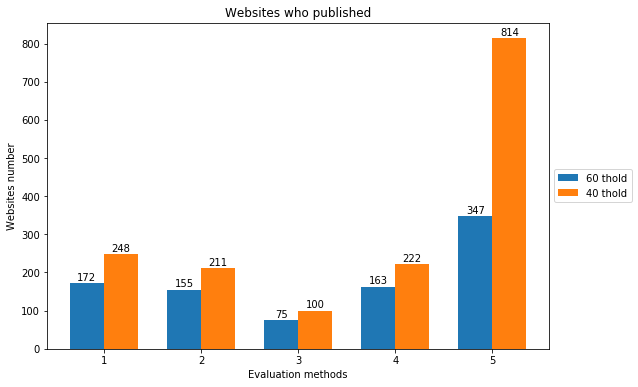

In [5]:
i = 0
generate_plot(i, stp)
plt.show()

### Percentuale siti con pubblicazioni

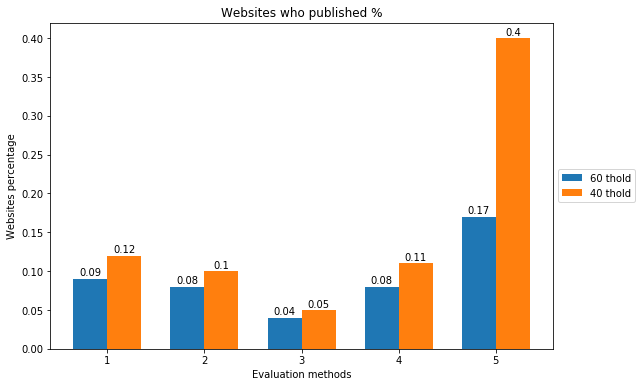

In [6]:
i = 1
generate_plot(i, stp)
plt.show()

### Numero di pdf utili
Si nota che il numero di pdf è sempre maggiore del numero di siti web che pubblicano, questo perchè circa il __18%__ dei siti pubblica un numero che varia da 2 a 4 di pdf che sono ritenuti utili.
Può succedere perchè in alcuni casi sono presenti traduzioni dello stesso file, oppure un riassunto accompagnato dal file completo.

Ritengo che si possa accettare uno scenario del genere per il momento, per poi gestirlo nella successiva parte di analisi semantica del testo, andando ad inserire tutti i file per ogni azienda. 
Sarà poi lo score ad ordinarli per rilevanza.

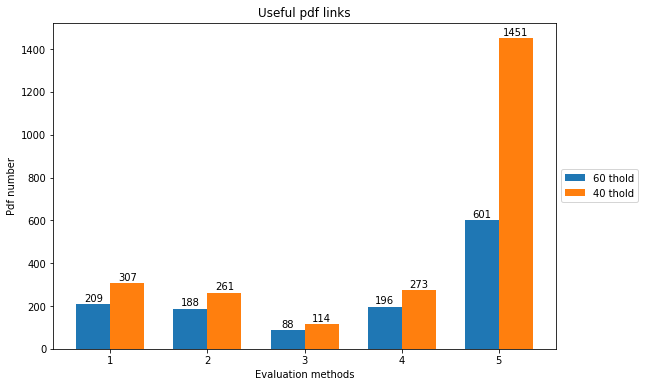

In [7]:
i = 2
generate_plot(i, stp)
plt.show()

### Percentuale di file pdf utili

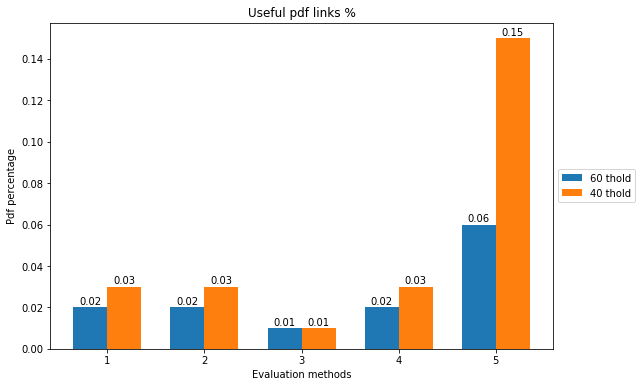

In [8]:
i = 3
generate_plot(i, stp)
plt.show()

### Profondità media dei file

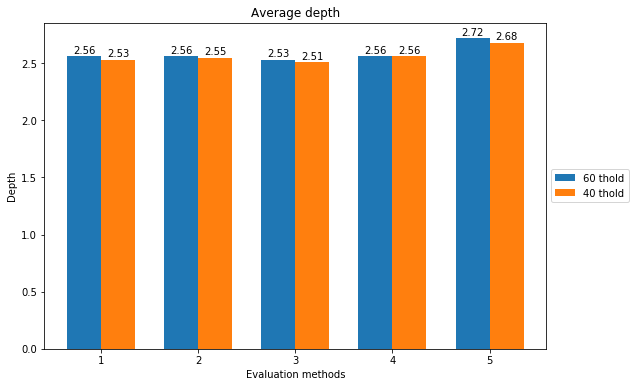

In [9]:
i = 4
generate_plot(i, stp)
plt.show()

### Numero di link presenti in homepage

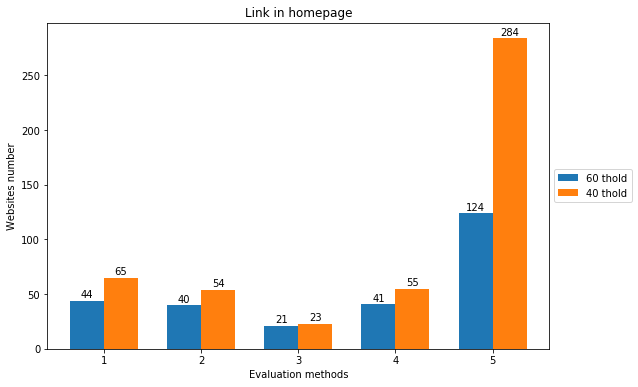

In [10]:
i = 5
generate_plot(i, stp)
plt.show()

# File processing

Dopo aver ottenuto la lista di link ( è stata utilizzata la lista ottenuta dalla prima condizione tra quelle testate, essendo quella che tiene in considerazione più file ) i pdf sono stati scaricati e ne è stato estratto il contenuto.

Purtroppo il valore iniziale di riscontri si è ristretto a causa di problemi con alcuni file pdf, risultati non convertibili o scaricabili.

In [11]:
csv_source = "pdf_ocr/stats.csv"
data = pd.read_csv(csv_source) 
data

,stats,value
0,total files,307
1,file to process,239
2,file processed,218


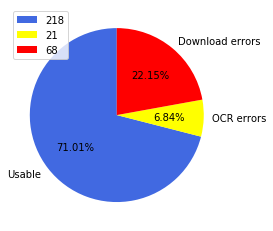

In [12]:
labels = 'Usable', 'OCR errors', 'Download errors'

val = list(data['value'])
sizes = [val[2], val[1] - val[2], val[0] - val[1]]
colors = ['royalblue', 'yellow', 'red']

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, colors=colors, autopct='%1.2f%%', startangle=90)
plt.legend(sizes, loc="best")

plt.show()

# Indicizzazione Elastic

Ottenuto il contenuto dei file è stato creato un indice elasticsearch, contenente:

1. id atoka dell'azienda
2. nome
3. indirizzo
4. ricavi
5. numero di dipendenti
6. testo contenuto nel documento pdf
7. entità principali del testo
8. tutte le entità del testo
9. url del file pdf
10. score della funzione evaluate sul singolo link

Le informazioni sulle aziende sono state ottenute con Atoka API, mentre quelle sulle entità tramite Dandelion API. 

## Statistiche popolazione

In [79]:
# plots

# Analisi entità

# Latent Dirichlet Allocation

Per meglio capire gli argomenti trattati nei bilanci è stato usato un modello Latent Dirichlet Allocation.
L'insieme di parole per ogni documento è stato ottenuto dalle entità estratte con Dandelion, esse sono poi state tradotte in inglese poichè i documenti scaricati presentavano lingue differenti.

I modelli sono stati creati provando a considerare sia tutte le entità, sia solo quelle principali.

Sono qui rappresentati due modelli, il primo considera tutte le entità, successivamente solo quelle principali, presenti nei documenti, il secondo si basa su un preprocessing più restrittivo: sono mantenute solo le entità che compaiono in almeno N documenti distinti. 

# Modelli su tutte le entità

A seguire i modelli senza e con vincoli di frequenza sulla lista completa di entità per ogni documento.

## Modello senza vincoli di frequenza - entità complete

Il primo modello non presenta viconli sulle keyword.
### Preprocessing

Il primo passo sta nella preprocessazione dei dati: si parte dalla lista di entità per ogni documento, e si arriva alle strutture necessarie ad allenare il modello, ovvero:
1. dtm_tf : frequency vector
2. tf_vectorizer: count vectorizer contentente il vocabolario estratto dai documenti

In [13]:
csv_input = "elasticsearch_utilities/stats/input_all_entities_en.csv"

data = pd.read_csv(csv_input)
data.head()

,elastic_index,entities
0,1,Secret_Intelligence_Service no Open_Systems_In...
1,2,Sustainability History Scientific_research Sus...
2,3,Board_of_Directors economy Quality_of_life Com...
3,4,Rosia_Montana Value_added Recycling circular_E...
4,5,Financial_statements Product_(economics) Work ...


L'input è preprocessato ottenendo le strutture utili a creare successivamente il modello.

In [14]:
from lda_topic_model import preprocess, print_vocab

dtm_tf, tf_vectorizer = preprocess("elasticsearch_utilities/stats/input_all_entities_en.csv")

print_vocab(tf_vectorizer.vocabulary_)

Total words in vocabulary : 24646 

Words:

'secret_intelligence_service' : 19536
'open_systems_interconnection' : 15581
'galactic_standard_calendar' : 8997
'autonomous_province_of_trento' : 2103
'natural_resource' : 14809
'gender_' : 9138
'social_sciences' : 20243
'technology' : 21568
'vita' : 23724
'environment_' : 7377
...


### Creazione modello

Il modello viene creato partendo dai dati preprocessati, ovvero dalle entità trovate per ogni documento.

Lo scopo è quello di capire di cosa si parla nella raccola di documenti, andando a trovare degli argomenti formati dalle parole presenti in ogni documento.

In [73]:
%%capture
from sklearn.decomposition import LatentDirichletAllocation

topics = 8

lda = LatentDirichletAllocation(n_components = topics, doc_topic_prior= 0.5, topic_word_prior = 0.5, random_state=0)
lda.fit(dtm_tf)

### Visualizzazione

I topics trovati sono visualizzati con pyLDAvis.

In [74]:
import pyLDAvis
import pyLDAvis.sklearn
pyLDAvis.enable_notebook()

pyLDAvis.sklearn.prepare(lda, dtm_tf, tf_vectorizer)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.050007 -0.014990       1        1  21.445812
0     -0.064312  0.003358       2        1  19.724422
2     -0.078405 -0.043603       3        1  18.199484
3      0.061541  0.037763       4        1  13.832471
1      0.032895 -0.059636       5        1  13.568823
6      0.101344 -0.073752       6        1   6.146871
7      0.051229  0.107562       7        1   4.126547
4     -0.054285  0.043298       8        1   2.955571, topic_info=                       Term        Freq       Total Category  logprob  loglift
34           sustainability  120.000000  120.000000  Default  30.0000  30.0000
35  sustainable_development  100.000000  100.000000  Default  29.0000  29.0000
13                  economy  132.000000  132.000000  Default  28.0000  28.0000
5                 community  109.000000  109.000000  Default  27.0000  27.0000
14                   energy  120.000000  120.000000  Default  26.0000  26.0000
..                      ...         ...         ...      ...      ...      ...
35  sustainable_development    1.058468  100.579568   Topic8  -4.8785  -1.0326
33                 strategy    1.063386  101.711259   Topic8  -4.8739  -1.0392
7                  contract    1.087126  108.424438   Topic8  -4.8518  -1.0810
2                  business    1.120612  121.518733   Topic8  -4.8215  -1.1647
17           european_union    1.043932  116.232541   Topic8  -4.8923  -1.1911

[282 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
0         1  0.201609  behavior
0         2  0.302413  behavior
0         3  0.291213  behavior
0         4  0.123205  behavior
0         5  0.011200  behavior
...     ...       ...       ...
43        4  0.009823     water
43        5  0.255395     water
43        6  0.206280     water
43        7  0.019646     water
43        8  0.009823     water

[352 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 1, 3, 4, 2, 7, 8, 5])

## Modello con vincoli di frequenza - entità complete

Per il modello che segue è stato imposto un vincolo sulla presenza delle keyword in N documenti distinti, in modo da scartare quei termini strettamente legati al settore spefico della singola azienda autrice del bilancio.

A seguire la grandezza del vocabolario in relazione al al valore di N, espresso in percentuale sul totale.
Si nota che anche nel caso in cui N sia molto piccolo in percentuale, la grandezza del vocabolario si riduce di molto rispetto allo scenario mostrato in precedenza.

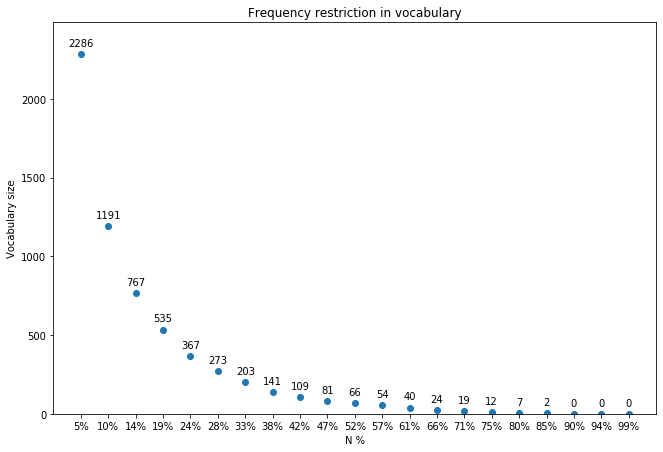

In [17]:
from lda_topic_model import generate_plot

stats_path = "lda_topic_model/data/vocabulary_stats_all_entities.csv"
generate_plot(stats_path)
plt.show()

Il procedimento è lo stesso mostrato per il modello precedente, cambia la funzione di preprocessing che implementa le restrizioni discusse sopra, è stato scelto un numero di topics minori, essendo il vocabolario molto più ristretto.

A seguire il modello che considera solo i termini presenti in almeno il 50% dei documenti.

In [75]:
from lda_topic_model import preprocess_freq_count


perc = 0.5
N = round(170 * perc)

dtm_tf, tf_vectorizer = preprocess_freq_count("elasticsearch_utilities/stats/input_all_entities_en.csv", N)
        
topics = 5
lda = LatentDirichletAllocation(n_components = topics, doc_topic_prior= 0.8, topic_word_prior = 0.8, random_state=0)
lda.fit(dtm_tf)

pyLDAvis.sklearn.prepare(lda, dtm_tf, tf_vectorizer)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.026236  0.080226       1        1  28.943850
1     -0.144006  0.081485       2        1  27.049379
3     -0.130794 -0.152455       3        1  22.342240
2      0.211605 -0.043160       4        1  12.565534
0      0.089431  0.033903       5        1   9.098998, topic_info=                  Term         Freq        Total Category  logprob  loglift
23                euro  2722.000000  2722.000000  Default  30.0000  30.0000
2   board_of_directors  2377.000000  2377.000000  Default  29.0000  29.0000
56      sustainability  9661.000000  9661.000000  Default  28.0000  28.0000
36          investment  1678.000000  1678.000000  Default  27.0000  27.0000
27             finance  1571.000000  1571.000000  Default  26.0000  26.0000
..                 ...          ...          ...      ...      ...      ...
50                risk   101.087605  1777.461369   Topic5  -4.4414  -0.4699
58          technology   133.649095  2570.259464   Topic5  -4.1621  -0.5595
4     business_process    62.983803  1138.229246   Topic5  -4.9145  -0.4973
56      sustainability   223.375145  9661.552232   Topic5  -3.6485  -1.3701
45              policy    70.408430  1682.561945   Topic5  -4.8030  -0.7768

[206 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
0         1  0.289606  air_pollution
0         2  0.666713  air_pollution
0         3  0.033297  air_pollution
0         4  0.000774  air_pollution
0         5  0.010067  air_pollution
...     ...       ...            ...
69        1  0.175134          world
69        2  0.163458          world
69        3  0.646049          world
69        4  0.007784          world
69        5  0.007784          world

[350 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 2, 4, 3, 1])

# Modelli liste di entità principali

I modelli che seguono sono creati e visualizzati seguendo lo stesso procedimento mostrato sopra, utilizzano però la lista di entità principali.

Lo scopo è quello di isolare i termini ritenuti secondari e dunque ricavare dei modelli più specifici.

## Modello senza vincoli di frequenza - entità principali

Il vocabolario è più ristretto rispetto al modello che considera tutte le entità del testo, è grande meno della metà.

In [19]:
dtm_tf, tf_vectorizer = preprocess("elasticsearch_utilities/stats/input_top_entities_en.csv")

print_vocab(tf_vectorizer.vocabulary_)

Total words in vocabulary : 10271 

Words:

'secret_intelligence_service' : 8168
'open_systems_interconnection' : 6405
'galactic_standard_calendar' : 3686
'autonomous_province_of_trento' : 785
'natural_resource' : 6082
'gender_' : 3744
'social_sciences' : 8462
'technology' : 9039
'vita' : 9899
'environment_' : 2973
...


In [76]:
topics = 5
lda = LatentDirichletAllocation(n_components = topics, doc_topic_prior= 0.5, topic_word_prior = 0.5, random_state=0)
lda.fit(dtm_tf)
pyLDAvis.sklearn.prepare(lda, dtm_tf, tf_vectorizer)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.025596  0.067376       1        1  28.899010
1     -0.140300  0.084560       2        1  28.161119
3     -0.139149 -0.146317       3        1  22.513889
2      0.207363 -0.056732       4        1  12.200039
0      0.097682  0.051112       5        1   8.225942, topic_info=                  Term         Freq        Total Category  logprob  loglift
23                euro  2721.000000  2721.000000  Default  30.0000  30.0000
2   board_of_directors  2371.000000  2371.000000  Default  29.0000  29.0000
56      sustainability  9673.000000  9673.000000  Default  28.0000  28.0000
27             finance  1568.000000  1568.000000  Default  27.0000  27.0000
36          investment  1677.000000  1677.000000  Default  26.0000  26.0000
..                 ...          ...          ...      ...      ...      ...
50                risk   114.754017  1777.434998   Topic5  -4.2137  -0.2423
4     business_process    68.406729  1137.796830   Topic5  -4.7310  -0.3135
58          technology   110.588667  2573.393209   Topic5  -4.2507  -0.6493
56      sustainability   228.212615  9673.554097   Topic5  -3.5262  -1.2490
45              policy    65.259421  1683.532224   Topic5  -4.7781  -0.7524

[208 rows x 6 columns], token_table=      Topic      Freq           Term
term                                
0         1  0.270186  air_pollution
0         2  0.685916  air_pollution
0         3  0.034064  air_pollution
0         4  0.000774  air_pollution
0         5  0.009290  air_pollution
...     ...       ...            ...
69        1  0.167897          world
69        2  0.191324          world
69        3  0.632541          world
69        4  0.003905          world
69        5  0.003905          world

[350 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 2, 4, 3, 1])

## Modello con vincoli di frequenza - entità principali

Si può notare che l'andamento della grandezza del vocabolario in funzione alla grandezza della restrizione applicata è pressochè uguale al precedente, l'altezza della curva è minore visto la dimensione più ristretta del vocabolario iniziale. 

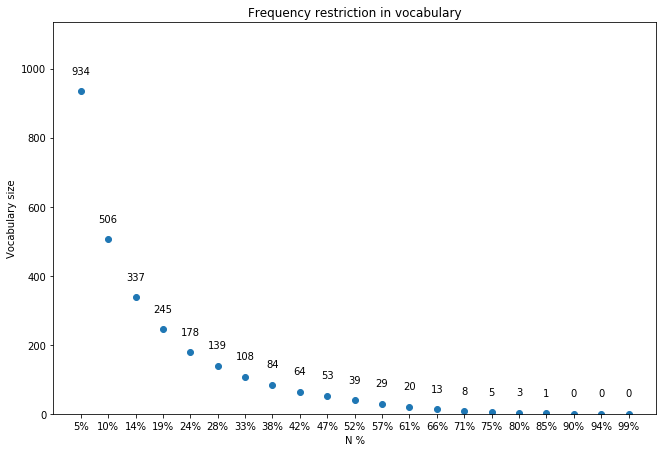

In [21]:
stats_path = "lda_topic_model/data/vocabulary_stats_top_entities.csv"
generate_plot(stats_path)
plt.show()

In [78]:
perc = 0.5
N = round(170 * perc)
        
dtm_tf, tf_vectorizer = preprocess_freq_count("elasticsearch_utilities/stats/input_top_entities_en.csv", N)
        
topics = 5
lda = LatentDirichletAllocation(n_components = topics, doc_topic_prior= 0.8, topic_word_prior = 0.8, random_state=0)
lda.fit(dtm_tf)

pyLDAvis.sklearn.prepare(lda, dtm_tf, tf_vectorizer)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.047506 -0.016106       1        1  21.373508
4     -0.022506 -0.034997       2        1  20.357690
3      0.075477 -0.023239       3        1  20.108506
2     -0.045065  0.032395       4        1  19.803275
1      0.039600  0.041947       5        1  18.357021, topic_info=                  Term        Freq       Total Category  logprob  loglift
12           economics   89.000000   89.000000  Default  30.0000  30.0000
15                euro  100.000000  100.000000  Default  29.0000  29.0000
40              value_   89.000000   89.000000  Default  28.0000  28.0000
16              europe   86.000000   86.000000  Default  27.0000  27.0000
3     business_process   88.000000   88.000000  Default  26.0000  26.0000
..                 ...         ...         ...      ...      ...      ...
1   board_of_directors   12.601334   89.061707   Topic5  -4.2278  -0.2604
5            community   14.422192  105.847676   Topic5  -4.0929  -0.2981
38            training   17.506056  130.107800   Topic5  -3.8991  -0.3107
30              safety   14.088992  115.838771   Topic5  -4.1163  -0.4116
6              company   14.923602  139.799538   Topic5  -4.0587  -0.5421

[187 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
0         1  0.389962  behavior
0         2  0.300828  behavior
0         3  0.100276  behavior
0         4  0.155985  behavior
0         5  0.055709  behavior
...     ...       ...       ...
43        1  0.187656     water
43        2  0.128396     water
43        3  0.088889     water
43        4  0.325928     water
43        5  0.276545     water

[220 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 5, 4, 3, 2])